In [164]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

#Loading the data

In [165]:
orders = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")
customers = pd.read_csv("customers.csv")

# ensure date format
orders['order_date'] = pd.to_datetime(orders['order_date'])

In [166]:
orders.head()

,order_id,customer_id,product_id,order_date,quantity
0,1,66,38,2023-08-09 08:39:23.971834,4
1,2,10,29,2023-09-08 08:39:23.971834,4
2,3,58,9,2023-07-29 08:39:23.971834,3
3,4,33,44,2023-09-13 08:39:23.971834,4
4,5,32,47,2023-07-24 08:39:23.971834,2


In [167]:
products.head()

,product_id,product_name,price,category
0,1,Ektorp Sofa,694,Sofas & Armchairs
1,2,Poäng Armchair,569,Sofas & Armchairs
2,3,Klippan Loveseat,639,Sofas & Armchairs
3,4,Malm Bed Frame,202,Beds
4,5,Hemnes Daybed,845,Beds


In [168]:
customers.head()

,customer_id,name
0,1,Customer_1
1,2,Customer_2
2,3,Customer_3
3,4,Customer_4
4,5,Customer_5


In [169]:
orders_products = orders.merge(
    products,
    on="product_id",
    how="left"
)

# revenue per order line
orders_products['revenue'] = (
    orders_products['quantity'] * orders_products['price']
)


#top selling product

###1. in terms of revenue

In [170]:
top_products_revenue = (
    orders_products
    .groupby('product_name')['revenue']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)
top_products_revenue.head(10)


,product_name,revenue
0,Brimnes Bed Storage,59521
1,Småstad Wardrobe,51688
2,Råskog Stool,50445
3,Docksta Table,46386
4,Nockeby Sofa,45646
5,Hemnes Daybed,44785
6,Fjälla Storage Box,43384
7,Bestå TV Bench,42320
8,Ektorp Sofa,40946
9,Valje Wall Cabinet,40140


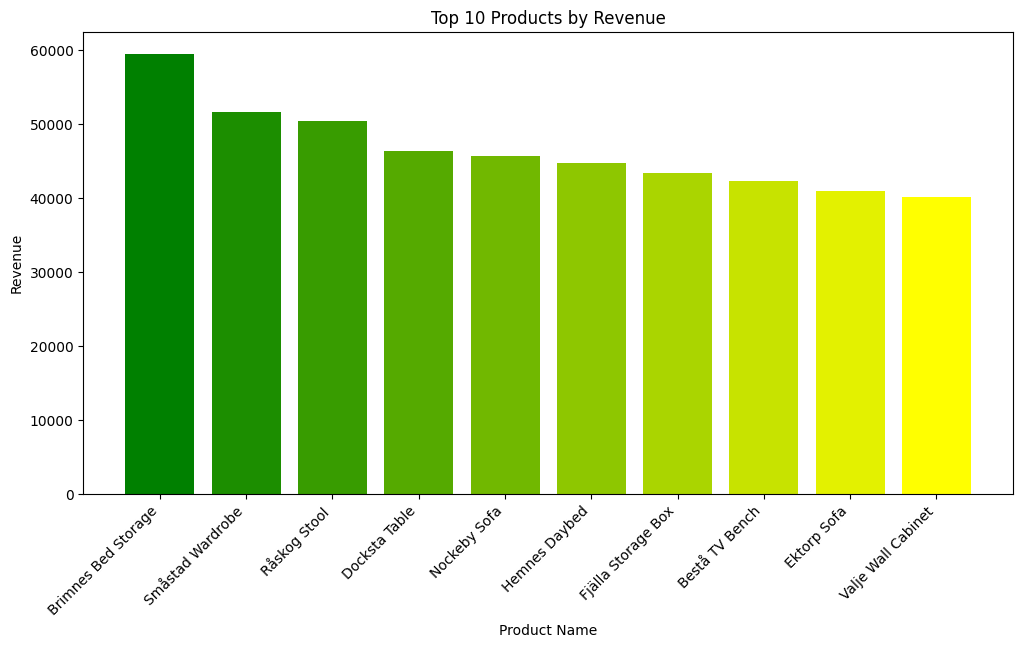

In [171]:
# Select top 10 products
top10 = top_products_revenue.head(10)

colors = LinearSegmentedColormap.from_list('green_yellow', ['green', 'yellow'])(np.linspace(0, 1, len(top10)))

# Plot bar chart
plt.figure(figsize=(12,6))
plt.bar(top10['product_name'], top10['revenue'], color=colors)
plt.title('Top 10 Products by Revenue')
plt.xlabel('Product Name')
plt.ylabel('Revenue')
plt.xticks(rotation=45, ha='right')
plt.show()


###2. in terems of unit sold

In [172]:
top_products_units = (
    orders_products
    .groupby('product_name')['quantity']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

top_products_units.head(10)


,product_name,quantity
0,Mackapar Shoe Storage,80
1,Brimnes Bed Storage,77
2,Poäng Armchair,63
3,Söderhamn Sofa Section,63
4,Melltorp Dining Table,62
5,Bekant Conference Table,62
6,Strandmon Wing Chair,61
7,Valje Wall Cabinet,60
8,Ektorp Sofa,59
9,Råskog Stool,59


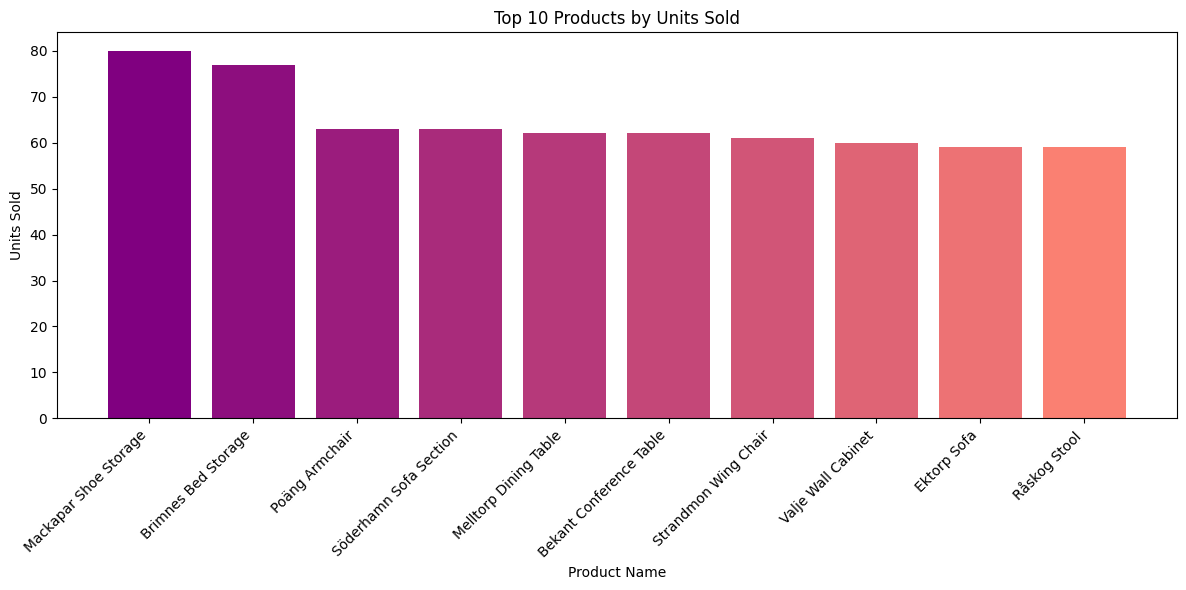

In [173]:
# Select top 10 products
top10_units = top_products_units.head(10)
colors = LinearSegmentedColormap.from_list('purple_salomon', ['purple','salmon',])(np.linspace(0, 1, len(top10)))

plt.figure(figsize=(12,6))
plt.bar(top10_units['product_name'], top10_units['quantity'], color=colors)
plt.title('Top 10 Products by Units Sold')
plt.xlabel('Product Name')
plt.ylabel('Units Sold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [174]:
latest_date = orders_products['order_date'].max()

last_month_start = (
    latest_date - pd.DateOffset(months=1)
)

last_month_orders = orders_products[
    orders_products['order_date'] >= last_month_start
]


# top clients for last month

In [175]:
last_month_clients = (
    last_month_orders
    .groupby('customer_id')['revenue']
    .sum()
    .reset_index()
    .merge(customers, on='customer_id', how='left')
    .sort_values(by='revenue', ascending=False)
)

last_month_clients.head(10)


,customer_id,revenue,name
0,1,19755,Customer_1
32,33,17302,Customer_33
3,4,16562,Customer_4
80,81,15147,Customer_81
51,52,14939,Customer_52
49,50,14807,Customer_50
43,44,14473,Customer_44
53,54,14367,Customer_54
17,18,14356,Customer_18
7,8,14156,Customer_8


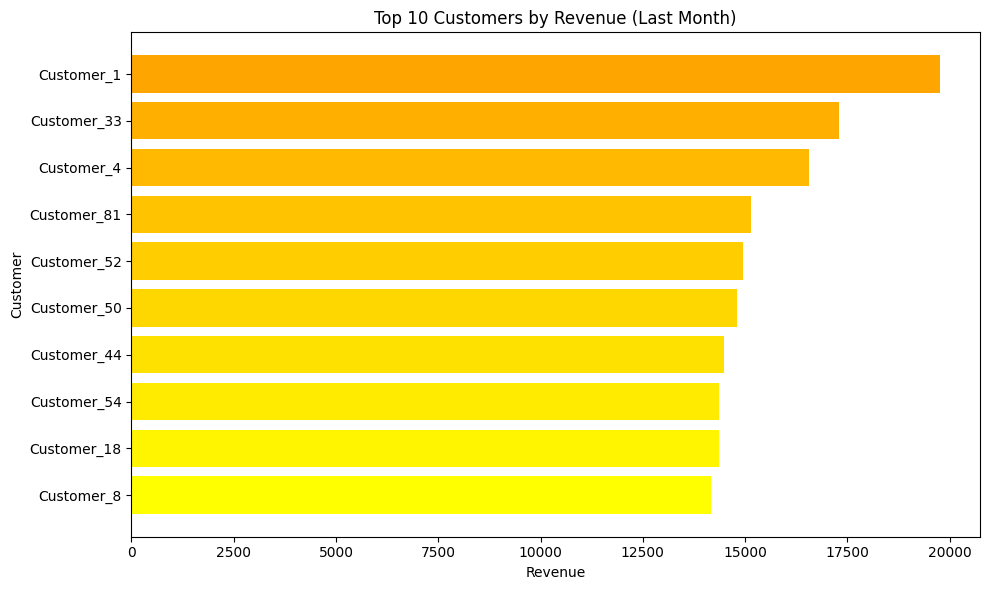

In [176]:
top10_customers = last_month_clients.head(10)

colors = LinearSegmentedColormap.from_list('orange_yellow', ['orange', 'yellow'])(np.linspace(0, 1, len(top10)))


# Horizontal bar chart
plt.figure(figsize=(10,6))
plt.barh(top10_customers['name'], top10_customers['revenue'], color=colors)
plt.title('Top 10 Customers by Revenue (Last Month)')
plt.xlabel('Revenue')
plt.ylabel('Customer')
plt.gca().invert_yaxis()  # highest revenue on top
plt.tight_layout()
plt.show()

In [177]:
orders = orders.merge(products, on='product_id', how='left')
orders['revenue'] = orders['quantity'] * orders['price']

# Introducing RFM to data

In [178]:
# Reference date = last date in dataset
analysis_date = orders['order_date'].max()

rfm = (
    orders
    .groupby('customer_id')
    .agg({
        'order_date': lambda x: (analysis_date - x.max()).days,  # Recency
        'order_id': 'nunique',                                   # Frequency
        'revenue': 'sum'                                         # Monetary
    })
    .reset_index()
)

rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']


In [179]:
rfm['R_score'] = pd.qcut(rfm['recency'], 4, labels=[4,3,2,1])
rfm['F_score'] = pd.qcut(rfm['frequency'], 4, labels=[1,2,3,4])
rfm['M_score'] = pd.qcut(rfm['monetary'], 4, labels=[1,2,3,4])


In [180]:
rfm['RFM_score'] = (
    rfm['R_score'].astype(str) +
    rfm['F_score'].astype(str) +
    rfm['M_score'].astype(str)
)


In [181]:
def segment_customer(row):
    if row['RFM_score'] >= '444':
        return 'Champions'
    elif row['R_score'] == '4':
        return 'Recent Customers'
    elif row['F_score'] == '4':
        return 'Loyal Customers'
    elif row['M_score'] == '4':
        return 'Big Spenders'
    elif row['R_score'] == '1':
        return 'At Risk'
    else:
        return 'Others'

rfm['segment'] = rfm.apply(segment_customer, axis=1)


In [182]:
rfm = rfm.merge(customers, on='customer_id', how='left')


In [183]:
rfm


,customer_id,recency,frequency,monetary,R_score,F_score,M_score,RFM_score,segment,name
0,1,0,18,27081,4,4,4,444,Champions,Customer_1
1,2,2,9,9347,3,2,1,321,Others,Customer_2
2,3,4,13,18077,3,4,4,344,Others,Customer_3
3,4,3,22,25717,3,4,4,344,Others,Customer_4
4,5,8,11,14913,2,3,3,233,Others,Customer_5
...,...,...,...,...,...,...,...,...,...,...
95,96,2,9,12264,3,2,2,322,Others,Customer_96
96,97,8,4,6088,2,1,1,211,Others,Customer_97
97,98,6,7,8915,2,1,1,211,Others,Customer_98
98,99,0,10,13181,4,2,3,423,Others,Customer_99


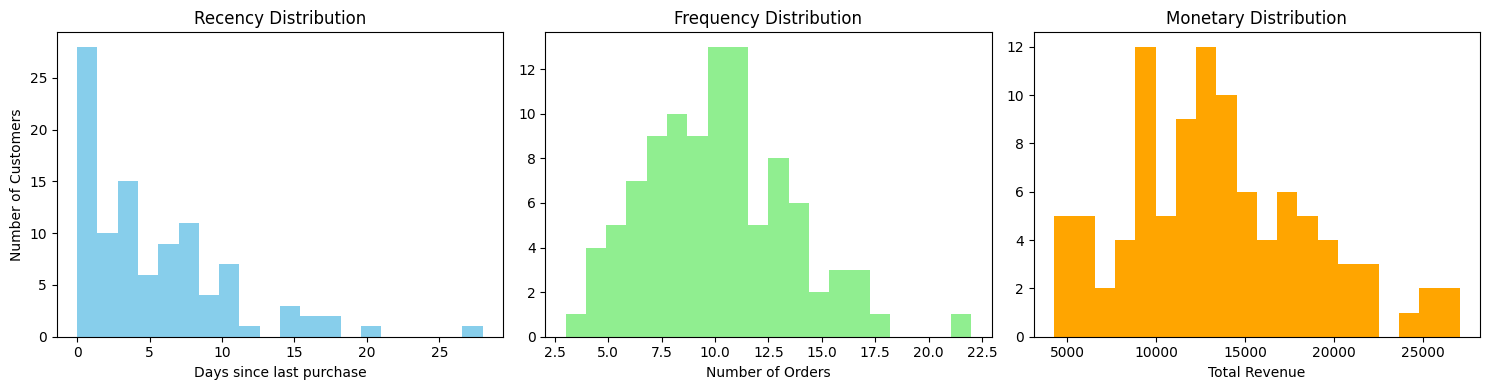

In [184]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))

# Recency
plt.subplot(1,3,1)
plt.hist(rfm['recency'], bins=20, color='skyblue')
plt.title('Recency Distribution')
plt.xlabel('Days since last purchase')
plt.ylabel('Number of Customers')

# Frequency
plt.subplot(1,3,2)
plt.hist(rfm['frequency'], bins=20, color='lightgreen')
plt.title('Frequency Distribution')
plt.xlabel('Number of Orders')

# Monetary
plt.subplot(1,3,3)
plt.hist(rfm['monetary'], bins=20, color='orange')
plt.title('Monetary Distribution')
plt.xlabel('Total Revenue')
plt.tight_layout()
plt.show()



In [185]:
ratings = pd.read_csv("ratings.csv")
products = pd.read_csv("products.csv")


#top reviewed item

In [186]:
top_reviewed_items = (
    ratings
    .groupby('product_id')
    .agg(
        total_reviews=('rating', 'count'),
        avg_rating=('rating', 'mean')
    )
    .reset_index()
    .merge(products, on='product_id', how='left')
    .sort_values(by='total_reviews', ascending=False)
)

top_reviewed_items.head(10)


,product_id,total_reviews,avg_rating,product_name,price,category
11,12,16,2.312500,Raskog Trolley,764,Storage Solutions
37,38,14,3.428571,Bekant Conference Table,441,Tables & Desks
6,7,13,3.000000,Lack Side Table,717,Tables & Desks
30,31,12,3.000000,Nockeby Sofa,787,Sofas & Armchairs
16,17,11,2.909091,Sinnerlig Pendant Lamp,610,Lighting
5,6,11,3.636364,Brimnes Bed Storage,773,Beds
27,28,11,2.545455,Tarva Nightstand,547,Decor
26,27,11,3.000000,Ivar Cabinet,687,Storage Solutions
8,9,11,2.818182,Micke Desk,19,Tables & Desks
31,32,11,3.181818,Kivik Chaise,926,Sofas & Armchairs


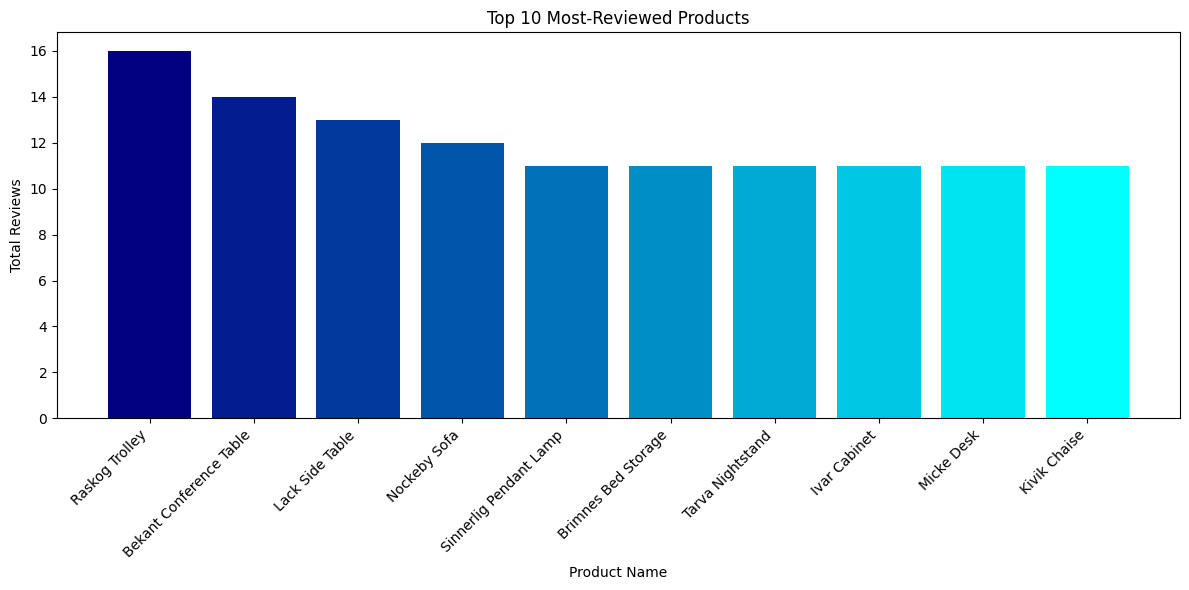

In [187]:

top10_reviews = top_reviewed_items.head(10)

colors = LinearSegmentedColormap.from_list('Navy_cyan', ['Navy', 'cyan'])(np.linspace(0, 1, len(top10)))

# Bar chart
plt.figure(figsize=(12,6))
plt.bar(top10_reviews['product_name'], top10_reviews['total_reviews'], color=colors)
plt.title('Top 10 Most-Reviewed Products')
plt.xlabel('Product Name')
plt.ylabel('Total Reviews')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#avg no. of review per customer

In [188]:
reviews_per_customer = (
    ratings
    .groupby('customer_id')
    .size()
    .reset_index(name='review_count')
)

avg_reviews_per_customer = reviews_per_customer['review_count'].mean()

avg_reviews_per_customer


np.float64(4.040404040404041)

In [189]:
reviews_per_customer

,customer_id,review_count
0,1,4
1,2,2
2,3,4
3,4,7
4,5,2
...,...,...
94,96,4
95,97,2
96,98,5
97,99,4
